In [4]:
!pip install gensim

    100% |████████████████████████████████| 22.6MB 55kB/s  eta 0:00:01
    100% |████████████████████████████████| 133kB 8.2MB/s eta 0:00:01
    100% |████████████████████████████████| 61kB 11.2MB/s ta 0:00:01
    100% |████████████████████████████████| 4.3MB 304kB/s eta 0:00:01
  Running setup.py bdist_wheel for smart-open ... done
  Stored in directory: /home/bharadwajvm/.cache/pip/wheels/b1/9e/7d/bb3d3b55c597e72617140a0638c06382a5f17283881eae163e
  Running setup.py bdist_wheel for bz2file ... done
  Stored in directory: /home/bharadwajvm/.cache/pip/wheels/81/75/d6/e1317bf09bf1af5a30befc2a007869fa6e1f516b8f7c591cb9
Successfully built smart-open bz2file
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
import os
import pandas as pd
import collections
import pickle
#import cPickle
import _pickle as cPickle

import scipy
from scipy import sparse
import numpy as np

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.cluster import KMeans
from sklearn.externals import joblib
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import numpy as np
import random

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns

import nltk
import nltk.data
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize,sent_tokenize

import re
import string
import time
import codecs
from Bio import Medline

import gensim
from gensim import corpora, models, similarities
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec, Word2Vec, CoherenceModel
from gensim.summarization import summarize

from collections import defaultdict

import pyLDAvis.gensim

import GapStatistics
import time

import bokeh

In [6]:
# Configurations and Variable Definitions

In [7]:
# Configuration: Data file name (it should be placed in the same ditrectory as the notebook file)
#DATA_FILE = DATA_FILE = '/data/pubmedtext.txt'
#test variables
# test_pmid = '27179337'
test_pmid = '28324318'

In [8]:
# constant variables
CLEANED_ABSTRACT_COL = 'cleaned_abstract'
SUMMARY_ABSTRACT_COL = 'summary_abstract'
CLEANED_MINIMAL_ABSTRACT_COL = 'cleaned_minimal_abstract'
TOKENIZED_CLEAN_ABS_COL = 'tokenized_c_abstract'
TOKENIZED_RAW_ABS_COL = 'tokenized_r_abstract'
TOKEN_COUNT_RAW_ABS_COL = 'token_count_r_abstract'
TOKEN_COUNT_CLEAN_ABS_COL = 'token_count_c_abstract'
TOKEN_COUNT_Unq_CLEAN_ABS_COL = 'token_count_unq_c_abstract'

In [5]:
# Input File Processing

In [6]:
#Dictionary of medline terms: https://www.nlm.nih.gov/bsd/mms/medlineelements.html
#Note that this differs from above by removing grants and affiliations in an effort to minimize exceptions
def read_medline_data_raw(filename):
    recs = Medline.parse(open(filename, 'r'))
    text = pd.DataFrame(columns = ["pmid", "articletitle", "journaltitle", "abstract"])
    count = 0
    for rec in recs:
        try:
            pmid = rec['PMID']
            atitle = rec["TI"]
            jtitle = rec["JT"]
            pubdate = rec["DP"]
            abstr = rec["AB"]
            text = text.append(pd.DataFrame([[pmid,atitle, jtitle,pubdate, abstr]],
                columns=["pmid", "articletitle", "journaltitle", "pubdate", "abstract"]),ignore_index=True, verify_integrity=True)            
        except:
            pass
    text.set_index(text.pmid)
    return text

In [7]:
# get the Data file path

print("Cell started at: " + time.strftime("%c"))
try:
    approot = os.path.dirname(os.path.realpath('__file__'))
except NameError:  # if it is the main script, not a module
    import sys
    approot = os.path.dirname(os.path.abspath(sys.argv[0]))
DATA_PATH = approot + DATA_FILE

# Read in MEDLINE formatted text
%time papers = read_medline_data_raw(DATA_PATH)
papers.to_pickle('data/papers_pain_EngFilter_6_5_2017_raw_oct17update')
papers.to_csv('data/papers_pain_EngFilter_6_5_2017_raw_oct17update.csv')
print("Cell completed at: " + time.strftime("%c"))

Cell started at: Thu May 24 17:21:47 2018
CPU times: user 132 ms, sys: 4.35 ms, total: 136 ms
Wall time: 371 ms
Cell completed at: Thu May 24 17:21:47 2018


In [8]:
papers = pd.read_pickle('data/papers_pain_EngFilter_6_5_2017_raw_oct17update')

In [9]:
papers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 5 columns):
abstract        61 non-null object
articletitle    61 non-null object
journaltitle    61 non-null object
pmid            61 non-null object
pubdate         61 non-null object
dtypes: object(5)
memory usage: 2.5+ KB


In [10]:
pubdatevalues = papers.pubdate.unique()
#pubdatevalues.tofile("pubdatevalues.csv", sep=',') Examine range of pubdates manually in csv

In [11]:
papers['pubdate_dtformat'] = pd.to_datetime(papers.pubdate, format='%Y', exact=False)
papers['pubyear'] = pd.DatetimeIndex(papers['pubdate_dtformat']).year
papers=papers.drop('pubdate_dtformat', axis=1)

In [12]:
papers.tail(10)

abstract  \
51  Non-steroidal anti-inflammatory drugs (NSAIDs)...   
52  We investigated the changes in characteristics...   
53  INTRODUCTION: Flupirtine, a nonopioid analgesi...   
54  Post-herpetic neuralgia means pain which occur...   
55  Antipsychotic drugs are the clinical standard ...   
56  BACKGROUND: Sex, race, and age disparities in ...   
57  BACKGROUND: Even though the use of a 25 gauge ...   
58  PURPOSE: We analyzed variables associated with...   
59  PURPOSE: To correlate computed tomography (CT)...   
60  Rheumatoid arthritis (RA) is one of the inflam...   

                                         articletitle  \
51  Anti-inflammatory and antinociceptive activiti...   
52  Expression of inflammatory and apoptosis facto...   
53  Efficacy and tolerability of flupirtine in sub...   
54  Modified Jaipur block for the treatment of pos...   
55  Dynamic regulation of dopamine and serotonin r...   
56  Patient demographic characteristics and facial...   
57  Comparison of post-dural puncture headache and...   
58  Predictors of long-term toxicity using three-d...   
59  Correlation of computed tomography imaging fea...   
60  The antinociceptive efficacy of HWTX-I epidura...   

                                         journaltitle      pmid      pubdate  \
51                   International immunopharmacology  21855654     2011 Nov   
52                   International immunopharmacology  21821152     2011 Nov   
53  International journal of clinical pharmacology...  22011688     2011 Nov   
54               International journal of dermatology  22004501     2011 Nov   
55  The international journal of neuropsychopharma...  21281560     2011 Nov   
56           International journal of nursing studies  21596378     2011 Nov   
57           International journal of nursing studies  21561619     2011 Nov   
58  International journal of radiation oncology, b...  20933342  2011 Nov 01   
59  International journal of radiation oncology, b...  20889265  2011 Nov 01   
60           International journal of sports medicine  22052031     2011 Nov   

    pubyear  
51     2011  
52     2011  
53     2011  
54     2011  
55     2011  
56     2011  
57     2011  
58     2011  
59     2011  
60     2011

In [13]:
papers.loc[papers['pubdate']=='2011 Nov']

abstract  \
0   OBJECTIVE: To define the value of multislice c...   
1   OBJECTIVES: To assess the feasibility of T2 ma...   
2   Intraosseous lipoma is an uncommon mesenchymal...   
3   OBJECTIVE: Aim of the present work is to asses...   
4   PURPOSE: There are few prospective studies on ...   
5   INTRODUCTION: Chronic pain has an impact on ps...   
6   PURPOSE: TNFalpha is an inflammatory mediator ...   
7   It is becoming increasingly evident that peopl...   
8   AIMS: Gastrointestinal symptoms such as pain, ...   
9   BACKGROUND: The clinical picture of pituitary ...   
10  INTRODUCTION: In early 2011, the FDA gave appr...   
11  Hereditary angioedema is a relatively rare gen...   
12  In acute and chronic pain, the objective of ph...   
13  There is a huge unmet need for novel medicines...   
14  Human pain biomarkers are based on standardize...   
15  Trigeminal neuralgia (TN) and persistent idiop...   
19  Patients who continue to suffer from severe an...   
26  BACKGROUND & AIMS: A randomized trial that com...   
27  BACKGROUND & AIMS: Although proteases control ...   
28  BACKGROUND & AIMS: The intestinal microbiomes ...   
31  Functional gastrointestinal disorders (FGIDs) ...   
32  OBJECTIVE: In patients with painful chronic pa...   
33  INTRODUCTION: Unexplained chest pain is potent...   
34  BACKGROUND: Recent evidence suggests that auto...   
35  Haemophilia patients experience acute pain dur...   
36  The authors describe a unique presentation of ...   
37  BACKGROUND: Minimally invasive video-assisted ...   
40  UNLABELLED: Many children consider getting a n...   
43  Naproxen is a non-steroidal anti-inflammatory ...   
44  BACKGROUND: Endometriosis is the most common g...   
47  Patients over 65 years of age with suspected h...   
48  INTRODUCTION: Patients with orthopaedic trauma...   
49  Psychological factors are capable of influenci...   
51  Non-steroidal anti-inflammatory drugs (NSAIDs)...   
52  We investigated the changes in characteristics...   
53  INTRODUCTION: Flupirtine, a nonopioid analgesi...   
54  Post-herpetic neuralgia means pain which occur...   
55  Antipsychotic drugs are the clinical standard ...   
56  BACKGROUND: Sex, race, and age disparities in ...   
57  BACKGROUND: Even though the use of a 25 gauge ...   
60  Rheumatoid arthritis (RA) is one of the inflam...   

                                         articletitle  \
0   Value of multislice computed tomography in the...   
1   Quantitative in vivo MRI evaluation of lumbar ...   
2   Intraosseous lipoma presenting as a sphenoid s...   
3   Combined occlusal and pharmacological therapy ...   
4   Surgery improves pain, function and quality of...   
5   The effect of repeated restraint stress in pai...   
6   Etanercept attenuates pain-related behavior fo...   
7   Effects of experimentally induced low back pai...   
8   Effects of isolated hyperinsulinaemia on senso...   
9          Hypopituitarism in a HIV affected patient.   
10  Extended-release gabapentin in post-herpetic n...   
11  Human pasteurized C1-inhibitor concentrate for...   
12  Pharmacokinetic-pharmacodynamic modeling in ac...   
13  Biologics: the next-generation therapeutics fo...   
14  Optimizing the early phase development of new ...   
15  Trigeminal neuralgia and persistent idiopathic...   
19  Spinal cord stimulation for long-term treatmen...   
26  Long-term outcomes of endoscopic vs surgical d...   
27  Cathepsin S is activated during colitis and ca...   
28  Gastrointestinal microbiome signatures of pedi...   
31  The balancing act: endogenous modulation of pa...   
32  Altered brain microstructure assessed by diffu...   
33  Response of unexplained chest pain to proton p...   
34  Frequency of pain crises in sickle cell anemia...   
35  Assessment and management of pain in haemophil...   
36    Celiac disease presenting as severe osteopenia.   
37  Minimally invasive video-assisted thyroidectom...   
40  Children's fear during procedural pain: prelim... 

In [14]:
papers.journaltitle.nunique()

39

In [15]:
papers.to_pickle('data/papers_pain_EngFilter_6_5_2017_raw_oct17update_Mar18year')
papers = pd.read_pickle('data/papers_pain_EngFilter_6_5_2017_raw_oct17update_Mar18year')

In [16]:
# Text Cleanup & Tokenization

In [17]:
## Remove "all-caps:" section headers, punctuation marks, numbers, and option for words in all capital letters

In [18]:
# This function will use regular expressions to remove all:
#  (1) words/phrases in all caps followed by :, (if filter_all_caps = True, eveything all-caps will be removed)     
#  (2) numbers
#  (3) one letter words (such as n or p or other mathematical symbols)
#  (4) punctuation marks
# return value is the list of all filtered words (except for numbers), and the clean abstracts

# A utility function for flattening the lists
def flatten(l):
    for el in l:
        if isinstance(el, collections.Iterable) and not isinstance(el, str):
            for sub in flatten(el):
                yield sub
        else:
            yield el

# Filter text as described above            
def filterText(abstracts, filter_all_caps = False):    
    #define the regex pattern
    regex = re.compile('[%s]' % re.escape(re.sub('-', '', string.punctuation)))
    if filter_all_caps:
        pattern = regex.pattern + r"|\b[A-Z]{2,}|[0-9]+|\b\w\b|\d-\d|\W-\W|\s-\s" 
    else:
        pattern = regex.pattern + r"|(((\s|^)[A-Z]{2,}(,)*)*)(\s|^)(\b[A-Z]{2,}):|[0-9]+|\b\w\b|\d-\d|\W-\W|\s-\s" 
    
    #The list of all filtered words (except for numbers)
    # convert to a falttened set for faster results
    all_filtered_series = abstracts.apply(lambda d: re.findall(pattern, d))
    all_filtered = set(flatten(all_filtered_series.tolist()))
    non_digit_filtered = [y for y in all_filtered if not y.isdigit()]
    
    #remove whatever needs to be filtered
    abstracts = abstracts.apply(lambda d: re.sub(pattern, '', d))
    abstracts = abstracts.apply(lambda d: re.sub('s-s', '', d))
    
    return abstracts, non_digit_filtered

In [19]:
## Remove stop words

In [20]:
# This function will replace all the stop words, it also gets rid of the whitespaces
def removeWord(text, stop_list):
    new_text = []
    
    #first convert to a list
    text_list = str.split(text)
    
    #check for stop words
    for x in text_list:
        if x not in stop_list:
            new_text.append(x)
    
    #convert back to string
    new_text_str = ' '.join(new_text)
    
    return new_text_str

# This function will remove stop words using NLTK stop word list
# It will return processed abstracts and stop word list
def removeStopWords(abstracts):         
    # use NLTK's default stop word list
    stop_set = set(stopwords.words('english'))
    
    # find all stop words and remove them
    abstracts = abstracts.apply(lambda d: removeWord(d, stop_set))
    
    return abstracts, stop_set

In [21]:
## Convert to lower case, tokenize

In [22]:
# This fuction will convert everything to lower-case
def changeToLowerCase(abstracts):  
    abstracts = abstracts.apply(lambda d: d.lower())
    return abstracts

In [23]:
# This function will tokenize all sentences
def tokenizeAbstracts(abstracts):  
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = abstracts.apply(lambda d: tokenizer.tokenize(d))
    return tokens

In [24]:
## Combine Preprocess Functions

In [25]:
def preprocessAbstracts(abstracts):    
    # Remove all-caps words, numbers, 1-letter words, punctuation marks 
    abstracts, filtered = filterText(abstracts, filter_all_caps= False)
    
    # conevrt to lower-case
    abstracts = changeToLowerCase(abstracts)
    
    # Remove stop words
    abstracts, stop_list = removeStopWords(abstracts)
    filtered = filtered + list(stop_list)
    
    # tokenize
    tokens = tokenizeAbstracts(abstracts)
    
    return abstracts, tokens, filtered

In [26]:
# This can be helpful for word2vec models that need minimal preprocessing
def minimallyPreprocessAbstracts(abstracts):
    #define the regex pattern
    regex = re.compile('[%s]' % re.escape(re.sub('-', '', string.punctuation)))
    pattern = regex.pattern + r"|[0-9.]+" 
    
    #remove whatever needs to be filtered
    abstracts = abstracts.apply(lambda d: re.sub(pattern, '#NUM', d))
    abstracts = abstracts.apply(lambda d: re.sub('s-s', '', d))
    return abstracts

In [27]:
## Apply preprocessing

In [28]:
# preprocess the abstracts
papers[CLEANED_ABSTRACT_COL], papers[TOKENIZED_CLEAN_ABS_COL], filtered = preprocessAbstracts(papers.abstract)
papers[CLEANED_MINIMAL_ABSTRACT_COL] = minimallyPreprocessAbstracts(papers.abstract)
%time papers[TOKENIZED_RAW_ABS_COL] = tokenizeAbstracts(papers.abstract)
# pre-compute the token counts
papers[TOKEN_COUNT_CLEAN_ABS_COL] =papers[TOKENIZED_CLEAN_ABS_COL].map(lambda text: len(text))
papers[TOKEN_COUNT_RAW_ABS_COL] =papers[TOKENIZED_RAW_ABS_COL].map(lambda text: len(text))
papers[TOKEN_COUNT_Unq_CLEAN_ABS_COL] =papers[TOKENIZED_CLEAN_ABS_COL].map(lambda text: len(set(text)))

CPU times: user 4.26 ms, sys: 26 µs, total: 4.28 ms
Wall time: 4.29 ms


In [29]:
#Show list of filtered terms
print(filtered)

['', 'OPINION', 'METHODS', 'INTRODUCTION', 'AIMS', 'MATERIALS', ' AND', ' METHODS AND', 'METHOD', ' MATERIALS AND', 'BACKGROUND', ' RESULTS AND', 'COVERED', 'PARTICIPANTS', ' AREAS', 'PURPOSE', ' ', 'PATIENTS', 'AIM', ' DESIGN AND', 'SETTINGS', ' CASE', ' PATIENTS AND', 'OBJECTIVE', 'UNLABELLED', 'CONCLUSION', 'BACKGROUND AND', 'OBJECTIVES', 'RESULTS', 'DESIGN', 'LIMITATIONS', 'REPORT', ' EXPERT', 'CONCLUSIONS', 'itself', 'shan', 'was', 'wouldn', 'didn', "isn't", 'then', "won't", 'when', 'ain', 'into', 'he', 'there', 'her', "doesn't", 'ours', 'has', 'as', 'm', 'needn', 'both', 'herself', 'll', 'mightn', 'that', 'yourself', 'other', 'hers', 'himself', 'very', "haven't", 'the', "don't", 'wasn', 'are', 'after', 'over', 'and', 've', 'yours', 'here', 'through', 'those', 'shouldn', "it's", "aren't", 'hadn', 'being', 'this', 'so', 'having', "you've", 'now', 'you', 'or', 'where', 'be', 'she', 'by', 'my', 'a', 'an', 'him', 'most', "hadn't", 'own', 'o', "couldn't", "she's", "shan't", 'if', 'myse

In [9]:
#papers.to_pickle('data/papapers_pain_EngFilter_6_5_2017_raw_preprocessed_oct17update_Mar18years')
%time papers = pd.read_pickle('data/papapers_pain_EngFilter_6_5_2017_raw_preprocessed_oct17update_Mar18years')

CPU times: user 13.4 s, sys: 4.15 s, total: 17.5 s
Wall time: 17.5 s


In [10]:
papers

abstract  \
0       pH-sensitive nonionic surfactant vesicles (nio...   
1       BACKGROUND: The prevalence of migraine with co...   
2       BACKGROUND: Identification of subgroups of pat...   
3       BACKGROUND: Burning Mouth Syndrome (BMS) is a ...   
4       BACKGROUND: Despite their huge epidemiological...   
5       BACKGROUND: Calcitonin gene-related peptide (C...   
6       BACKGROUND: The aim of this study was to inves...   
7       BACKGROUND: Cardiac cephalalgia (CC) is a rare...   
8       BACKGROUND: In the emergency setting, non-trau...   
9       BACKGROUND: A better understanding of potentia...   
10      BACKGROUND: Frequent mild head injuries or con...   
11      BACKGROUND: We investigated the prevalence of ...   
12      BACKGROUND: Hyperbaric oxygen (HBO) therapy is...   
13      CONTEXT: (-)-alpha-Bisabolol (BISA) is a sesqu...   
14      CONTEXT: Pterocephalus hookeri (C. B. Clarke) ...   
15      CONTEXT: The leaves of Albizia zygia (DC.) J.F...   
16      CONTEXT: Linalool oxide (OXL) (a monoterpene) ...   
17      Infective spondylodiscitis is a rare disease. ...   
18      BACKGROUND: The prognostic role of hypertensio...   
19      BACKGROUND: Western Pygmy Rattlesnake (WPR) en...   
20      Chronic neuropathic pain is a complicated cond...   
21      The study aimed to evaluate the effect of Zing...   
22      Background: The HEART (History, Electrocardiog...   
23      Background: High-sensitivity assays for cardia...   
24      A literature review identified six placebo-con...   
25      BACKGROUND: Coronary revascularization guided ...   
26      BACKGROUND: The instantaneous wave-free ratio ...   
27      OBJECTIVE: A majority of patients with advance...   
28      BACKGROUND: The pathophysiology of functional ...   
29      BACKGROUND: The diagnosis of gastro-oesophagea...   
...                                                   ...   
201585  Spinal anesthesia is an essentially safe proce...   
201586  Banthine(R) was used in the treatment of patie...   
201587  Menstruation, a physiologic function, should b...   
201588  The author report clinical experience with 212...   
201589  Experience with caudal analgesia for obstetric...   
201590  In fifteen cases of amebiasis masquerading as ...   
201591  The primary radiologic evidence of intra-abdom...   
201592  The most disabling form of Parkinsonism is tha...   
201593  In spite of widely dispersed modern knowledge ...   
201594  In a review of the records in 50 cases of ameb...   
201595  In over 400 treatments with procaine intraveno...   
201596  Chronic relapsing pancreatitis is a disease of...   
201597  The cause of endometriosis is not known. The i...   
201598  Although one-eighth to one-tenth of all fractu...   
201599  1. Frontal lobotomy is an effective procedure ...   
201600  The nature of tendinitis and bursitis of the s...   
201601  Fifty-four patients with various classificatio...   
201602  Neck and shoulder pains are presenting or inci...   
201603  Five hundred consecutive admissions to the rhe...   
201604  AIM: Rehabilitation of the edentulous atrophic...   
201605  AIMS: To conduct a systematic review to determ...   
201606  AIMS: To assess the influence of clenching sid...   
201607  AIMS: To determine if pressure pain thresholds...   
201608  AIMS: To evaluate the transient effects of ort...   
201609  AIMS: To analyze the methodologic quality, sum...   
201610  AIMS: To investigate the relationship between ...   
201611  AIMS: To evaluate whether a biobehavioral inte...   
201612  We propose that trigger-point dry needle (TrP-...   
201613  Erythrocytosis, or increased red blood cell ma...   
201614  PURPOSE: Juvenile idiopathic arthritis (JIA) i...   

                                             articletitle  \
0       pH-sensitive niosomes: Effects on cytotoxicity...   
1       Level of physical activity, well-being, stress...   
2       Identification of subgroups of patients with t...   
3       Refractory bur

In [11]:
#Test
print('Original Abstract: \n', papers.abstract[papers.pmid == test_pmid])
print('\nCleaned Abstract: \n', papers.loc[papers.pmid == test_pmid, CLEANED_ABSTRACT_COL])
print('\nTokenized Abstract: \n', papers.loc[papers.pmid == test_pmid, TOKENIZED_CLEAN_ABS_COL])
print('\nMinimally Processed Abstract: \n', papers.loc[papers.pmid == test_pmid, CLEANED_MINIMAL_ABSTRACT_COL])
papers[(papers.pmid == test_pmid)]

Original Abstract: 
 4    BACKGROUND: Despite their huge epidemiological...
Name: abstract, dtype: object

Cleaned Abstract: 
 4    despite huge epidemiological impact primary he...
Name: cleaned_abstract, dtype: object

Tokenized Abstract: 
 4    [despite, huge, epidemiological, impact, prima...
Name: tokenized_c_abstract, dtype: object

Minimally Processed Abstract: 
 4    BACKGROUND#NUM Despite their huge epidemiologi...
Name: cleaned_minimal_abstract, dtype: object


abstract  \
4  BACKGROUND: Despite their huge epidemiological...   

                                        articletitle  \
4  Botulinum neurotoxin type A for the treatment ...   

                       journaltitle      pmid   pubdate  pubyear  \
4  The journal of headache and pain  28324318  2017 Dec     2017   

                                    cleaned_abstract  \
4  despite huge epidemiological impact primary he...   

                                tokenized_c_abstract  \
4  [despite, huge, epidemiological, impact, prima...   

                            cleaned_minimal_abstract  \
4  BACKGROUND#NUM Despite their huge epidemiologi...   

                                tokenized_r_abstract  token_count_c_abstract  \
4  [BACKGROUND, Despite, their, huge, epidemiolog...                     113   

   token_count_r_abstract  token_count_unq_c_abstract  
4                     168                          85

In [12]:
# Topic Modeling with LDA

In [13]:
## Create Corpus, Dictionary, and Related Text Constructs

In [14]:
# create a dictionary mapping words to ids
abstract_list = papers[TOKENIZED_CLEAN_ABS_COL].values
ca_gs_dictionary = corpora.Dictionary(abstract_list)

#remove extremes (similar to tf-idf)
ca_gs_dictionary.filter_extremes(no_below=1, no_above=0.8)
ca_gs_dictionary.compactify()

In [15]:
#convert the dictionary to a bag of words
ca_gs_corpus = [ca_gs_dictionary.doc2bow(words) for words in abstract_list]
# corpora.mmcorpus.MmCorpus.serialize('data/ca_gensim.mm', corpus)
ca_gs_tfidf = models.TfidfModel(ca_gs_corpus)

In [16]:
## Topic Modeling via LDA

In [17]:
### Determine optimal number of topics through coherence testing

In [18]:
def LDA_compute_coherence_values(dictionary, corpus, texts, limit):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(2, limit, 6):
        model = models.ldamulticore.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=5, 
                                                 workers=16)
        model_list.append(model)
        coherencemodel = models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [19]:
LDA_model_list, LDA_coherence_values = LDA_compute_coherence_values(dictionary=ca_gs_dictionary, corpus=ca_gs_corpus, texts=abstract_list, limit=50)

In [20]:
print(LDA_model_list)
print(LDA_coherence_values)

[<gensim.models.ldamulticore.LdaMulticore object at 0x7f7a0e137438>, <gensim.models.ldamulticore.LdaMulticore object at 0x7f7b4b471a20>, <gensim.models.ldamulticore.LdaMulticore object at 0x7f7b4b471940>, <gensim.models.ldamulticore.LdaMulticore object at 0x7f7b906ec908>, <gensim.models.ldamulticore.LdaMulticore object at 0x7f7b8432acf8>, <gensim.models.ldamulticore.LdaMulticore object at 0x7f7a0e1374a8>, <gensim.models.ldamulticore.LdaMulticore object at 0x7f7a0e1374e0>, <gensim.models.ldamulticore.LdaMulticore object at 0x7f7a0e137550>]
[0.30706743839970085, 0.47521157480605675, 0.49239493745414936, 0.4996873843658201, 0.46285425408833736, 0.4876055304825436, 0.4866844899570925, 0.4874213572757142]


In [21]:
with open('LDA_model_list.pkl', 'wb') as f:
    pickle.dump(LDA_model_list, f)
    
with open('LDA_coherence_values.pkl', 'wb') as f:
    pickle.dump(LDA_coherence_values, f)

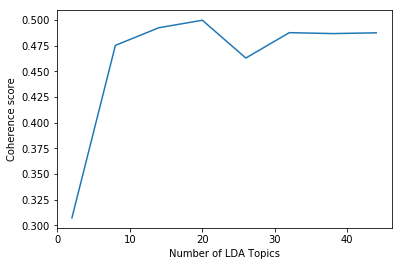

In [22]:
limit=50
x = range(2, limit, 6)
plt.plot(x, LDA_coherence_values)
plt.xlabel("Number of LDA Topics")
plt.ylabel("Coherence score")
# plt.legend(("LDA_coherence_values"), loc='best')
plt.show()

In [23]:
for m, cv in zip(x, LDA_coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3071
Num Topics = 8  has Coherence Value of 0.4752
Num Topics = 14  has Coherence Value of 0.4924
Num Topics = 20  has Coherence Value of 0.4997
Num Topics = 26  has Coherence Value of 0.4629
Num Topics = 32  has Coherence Value of 0.4876
Num Topics = 38  has Coherence Value of 0.4867
Num Topics = 44  has Coherence Value of 0.4874


In [24]:
num_of_LDA_topics = 40 #Derived from coherence testing of topic counts from 2 to 50 for LDA

In [25]:
### Run LDA with 40 topics

In [28]:
# %time lda = models.LdaModel(ca_gs_corpus, num_topics=num_of_LDA_topics, id2word =ca_gs_dictionary, update_every=5, passes=100)
%time lda_mc = models.ldamulticore.LdaMulticore(corpus=ca_gs_corpus, num_topics=num_of_LDA_topics, id2word=ca_gs_dictionary, passes=100, workers=3)

CPU times: user 3h 47min, sys: 23min 13s, total: 4h 10min 14s
Wall time: 6h 14min 12s


In [30]:
lda_mc.save("./data/mc_model_40topic_bharadwaj.lda")
lda_mc=gensim.models.LdaModel.load("./data/mc_model_40topic_bharadwaj.lda")

In [31]:
## Doc-Topic distribution

In [32]:
# Get document topics
all_topics = lda_mc.get_document_topics(ca_gs_corpus, minimum_probability=0)
all_topics[0]

[(0, 0.0002173913),
 (1, 0.0002173913),
 (2, 0.012915058),
 (3, 0.0002173913),
 (4, 0.023604823),
 (5, 0.0002173913),
 (6, 0.0002173913),
 (7, 0.0002173913),
 (8, 0.0002173913),
 (9, 0.0002173913),
 (10, 0.25974277),
 (11, 0.018585712),
 (12, 0.0002173913),
 (13, 0.0002173913),
 (14, 0.0002173913),
 (15, 0.0002173913),
 (16, 0.022886494),
 (17, 0.0002173913),
 (18, 0.0002173913),
 (19, 0.0002173913),
 (20, 0.0002173913),
 (21, 0.0002173913),
 (22, 0.012697987),
 (23, 0.0002173913),
 (24, 0.0002173913),
 (25, 0.07378815),
 (26, 0.0002173913),
 (27, 0.027555665),
 (28, 0.0002173913),
 (29, 0.14941353),
 (30, 0.0002173913),
 (31, 0.120327696),
 (32, 0.03632354),
 (33, 0.0002173913),
 (34, 0.026393505),
 (35, 0.16251177),
 (36, 0.0002173913),
 (37, 0.023229852),
 (38, 0.024588654),
 (39, 0.0002173913)]

In [33]:
## Prepare the Input files for Tensorboard

In [34]:
import gensim
import pandas as pd
import smart_open
import random
from smart_open import smart_open

In [47]:
len(doc_topics)

40

In [48]:
# create file for tensors
with smart_open('40_doc_lda_tensor.tsv','w') as w:
    for doc_topics in all_topics:
        for topics in doc_topics:
            w.write(str(topics[1])+ "\t")
        w.write("\n")
        
# create file for metadata
with smart_open('40_doc_lda_metadata.tsv','w') as w:
    w.write('articletitle\tjournaltitle\n')
    for j, k in zip(papers.articletitle, papers.journaltitle):
        w.write("%s\t%s\n" % (j, k))

In [49]:
tensors = []
for doc_topics in all_topics:
    doc_tensor = []
    for topic in doc_topics:
        if round(topic[1], 3) > 0:
            doc_tensor.append((topic[0], float(round(topic[1], 3))))
    # sort topics according to highest probabilities
    doc_tensor = sorted(doc_tensor, key=lambda x: x[1], reverse=True)
    # store vectors to add in metadata file
    tensors.append(doc_tensor[:5])

# overwrite metadata file
i=0
with smart_open('40_doc_lda_metadata.tsv','w') as w:
    w.write('articletitle\tjournaltitle\n')
    for j,k in zip(papers.articletitle, papers.journaltitle):
        w.write("%s\t%s\n" % (''.join((str(j), str(tensors[i]))),k))
        i+=1

In [37]:
# we upload the previous tensor file "doc_lda_tensor.tsv" and this new metadata file to http://projector.tensorflow.org/ . 

In [38]:
#Visualize using T-SNE [ Just change the tab in left ]

In [39]:
lda_mc.show_topic(topicid=0, topn=15)

[('studies', 0.034135792),
 ('trials', 0.029683243),
 ('evidence', 0.018823609),
 ('pain', 0.017664865),
 ('review', 0.013905962),
 ('acupuncture', 0.013857485),
 ('controlled', 0.01206504),
 ('data', 0.012056127),
 ('quality', 0.01165599),
 ('treatment', 0.009831932),
 ('included', 0.008777655),
 ('ci', 0.007950889),
 ('clinical', 0.007512459),
 ('analysis', 0.007285288),
 ('systematic', 0.0072765234)]

## pyLDAvis using PcoA

In [66]:
import pyLDAvis.gensim

viz1 = pyLDAvis.gensim.prepare(lda_mc, ca_gs_corpus, ca_gs_dictionary)
pyLDAvis.display(viz1)

In [67]:
 pyLDAvis.save_html(viz1, 'LDA_vis_PCoA_40')

## pyLDAvis using tsne

In [56]:
viz2 = pyLDAvis.gensim.prepare(lda_mc, ca_gs_corpus, ca_gs_dictionary,mds='tsne')
pyLDAvis.display(viz2)

In [ ]:
 pyLDAvis.save_html(viz2, 'LDA_vis_TSNE_40')

## Topic Networks

In [72]:
# get topic distributions
topic_dist = lda_mc.state.get_lambda()

# get topic terms
num_words = 50
topic_terms = [{w for (w, _) in lda_mc.show_topic(topic, topn=num_words)} for topic in range(topic_dist.shape[0])]

In [73]:
from scipy.spatial.distance import pdist, squareform
from gensim.matutils import jensen_shannon
import networkx as nx
import itertools as itt

# calculate distance matrix using the input distance metric
def distance(X, dist_metric):
    return squareform(pdist(X, lambda u, v: dist_metric(u, v)))

topic_distance = distance(topic_dist, jensen_shannon)

# store edges b/w every topic pair along with their distance
edges = [(i, j, {'weight': topic_distance[i, j]})
         for i, j in itt.combinations(range(topic_dist.shape[0]), 2)]

# keep edges with distance below the threshold value
k = np.percentile(np.array([e[2]['weight'] for e in edges]), 20)
edges = [e for e in edges if e[2]['weight'] < k]

In [74]:
import  plotly.offline as py
from plotly.graph_objs import *
import plotly.figure_factory as ff

py.init_notebook_mode()

# add nodes and edges to graph layout
G = nx.Graph()
G.add_nodes_from(range(topic_dist.shape[0]))
G.add_edges_from(edges)

graph_pos = nx.spring_layout(G)

In [75]:
# initialize traces for drawing nodes and edges 
node_trace = Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=Marker(
        showscale=True,
        colorscale='YIGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            xanchor='left'
        ),
        line=dict(width=2)))

edge_trace = Scatter(
    x=[],
    y=[],
    text=[],
    line=Line(width=0.5, color='#888'),
    hoverinfo='text',
    mode='lines')


# no. of terms to display in annotation
n_ann_terms = 10

# add edge trace with annotations
for edge in G.edges():
    x0, y0 = graph_pos[edge[0]]
    x1, y1 = graph_pos[edge[1]]
    
    pos_tokens = topic_terms[edge[0]] & topic_terms[edge[1]]
    neg_tokens = topic_terms[edge[0]].symmetric_difference(topic_terms[edge[1]])
    pos_tokens = list(pos_tokens)[:min(len(pos_tokens), n_ann_terms)]
    neg_tokens = list(neg_tokens)[:min(len(neg_tokens), n_ann_terms)]
    annotation = "<br>".join((": ".join(("+++", str(pos_tokens))), ": ".join(("---", str(neg_tokens)))))
    
    x_trace = list(np.linspace(x0, x1, 10))
    y_trace = list(np.linspace(y0, y1, 10))
    text_annotation = [annotation] * 10
    x_trace.append(None)
    y_trace.append(None)
    text_annotation.append(None)
    
    edge_trace['x'] += x_trace
    edge_trace['y'] += y_trace
    edge_trace['text'] += text_annotation

# add node trace with annotations
for node in G.nodes():
    x, y = graph_pos[node]
    node_trace['x'].append(x)
    node_trace['y'].append(y)
    node_info = ''.join((str(node+1), ': ', str(list(topic_terms[node])[:n_ann_terms])))
    node_trace['text'].append(node_info)
    
# color node according to no. of connections
for node, adjacencies in enumerate(G.adjacency()):
    node_trace['marker']['color'].append(len(adjacencies))

In [76]:
fig = Figure(data=Data([edge_trace, node_trace]),
             layout=Layout(showlegend=False,
                hovermode='closest',
                xaxis=XAxis(showgrid=True, zeroline=False, showticklabels=True),
                yaxis=YAxis(showgrid=True, zeroline=False, showticklabels=True)))

py.iplot(fig)